In [90]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [91]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

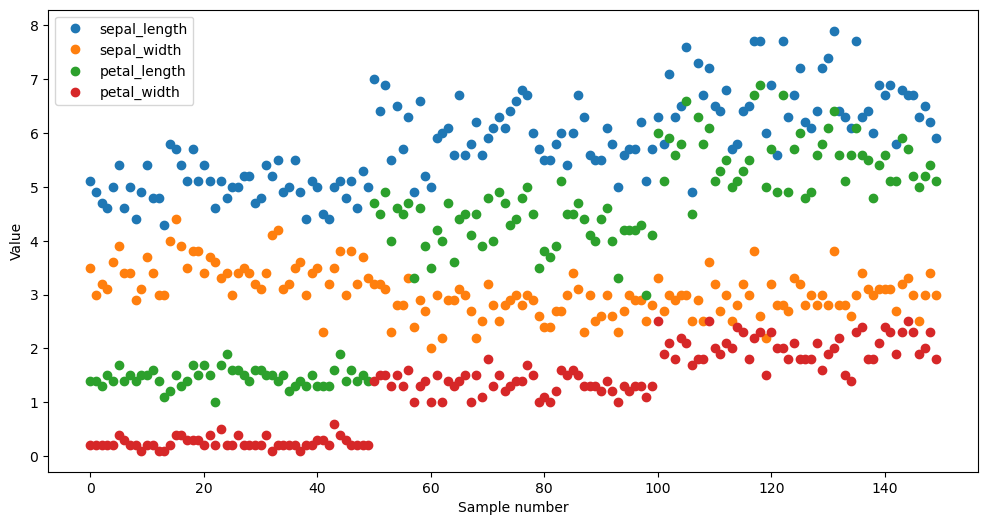

In [92]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [93]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [94]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

In [95]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


In [96]:
def createModel():
  #model architecture
  AnnIris=nn.Sequential(
    nn.Linear(4,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,3)
  )
  
  lossfun = nn.CrossEntropyLoss()
  
  optimizer = torch.optim.SGD(AnnIris.parameters(),lr=0.001)
  
  return AnnIris, lossfun, optimizer
  
  

In [97]:

#train the model

#global parameter
numepochs = 2500
batchSizes=[2**x for x in range(1,7)]

#Create a list

def trainTheModel():
  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []
  
  # loop over epochs
  for epochi in range(numepochs):
    
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    
    for X,y in train_loader:
      yHat=AnnIris(X)
      loss=lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # loss from this batch
      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
      batchLoss.append(loss.item())
      
    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))
    
    # test the model on the test data
    X,y = next(iter(test_loader))
    predlabels=torch.argmax(AnnIris(X),axis=1)
    testAcc.append(100*torch.mean((predlabels==y).float()).item())
    
  return trainAcc,testAcc,losses

In [98]:
# create a model
# AnnIris,lossfun,optimizer = createModel()

# train the model
# trainAcc,testAcc,losses = trainTheModel()

Batch size: 2
Test accuracy: 100.0
Train accuracy: 97.5
----------------------------------


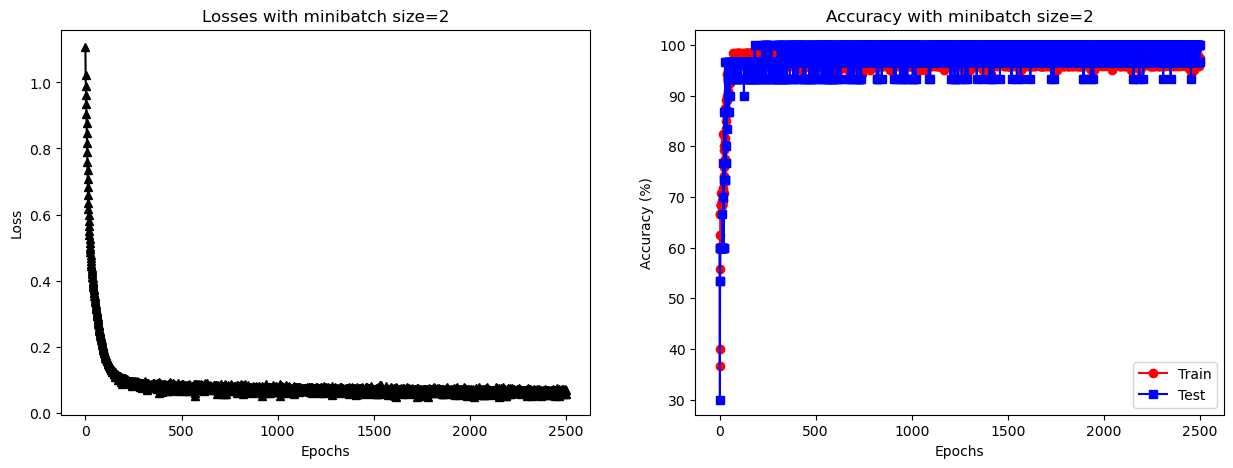

Batch size: 4
Test accuracy: 100.0
Train accuracy: 98.33333333333333
----------------------------------


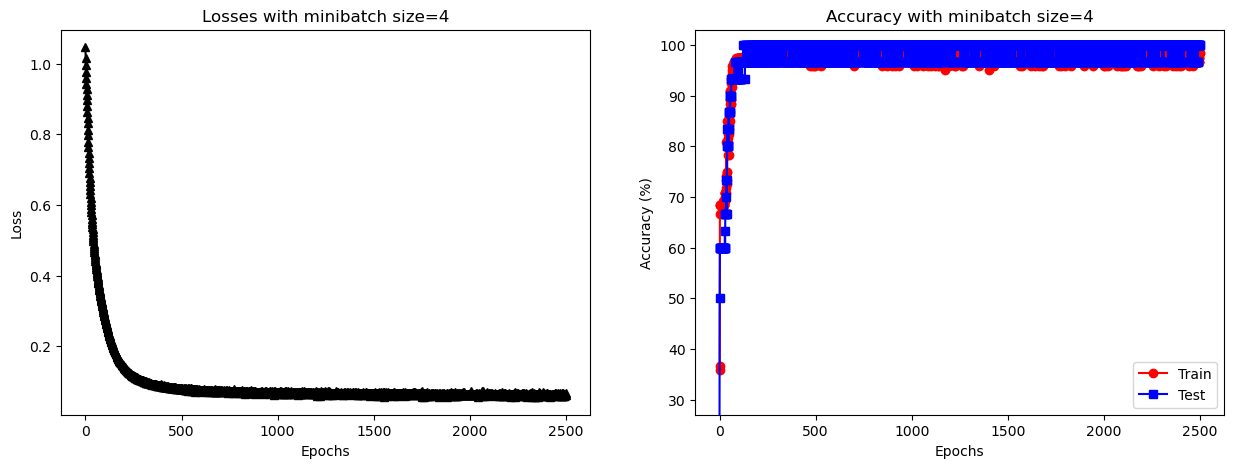

IndexError: index 8 is out of bounds for axis 1 with size 6

In [99]:
#Train the model for each bath in batch sizes
for batchsize in batchSizes:
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  AnnIris,lossfun,optimizer = createModel()
  trainAcc,testAcc,losses = trainTheModel()
  
  #store the results for all batchs
  accuracyResultsTrain = np.zeros((numepochs,len(batchSizes)))
  accuracyResultsTest  = np.zeros((numepochs,len(batchSizes)))
  accuracyResultsTrain[:,batchsize] = trainAcc
  accuracyResultsTest[:,batchsize]  = testAcc

  print('Batch size:', batchsize)
  print('Test accuracy:', testAcc[-1])
  print('Train accuracy:', trainAcc[-1])
  print('----------------------------------')
  # plot the results
  fig,ax = plt.subplots(1,2,figsize=(15,5))


  ax[0].plot(losses,'k^-')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_title('Losses with minibatch size=' + str(batchsize))

  ax[1].plot(trainAcc,'ro-')
  ax[1].plot(testAcc,'bs-')
  ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy (%)')
  ax[1].legend(['Train','Test'])
  ax[1].set_ylim([27,103])

  plt.show()

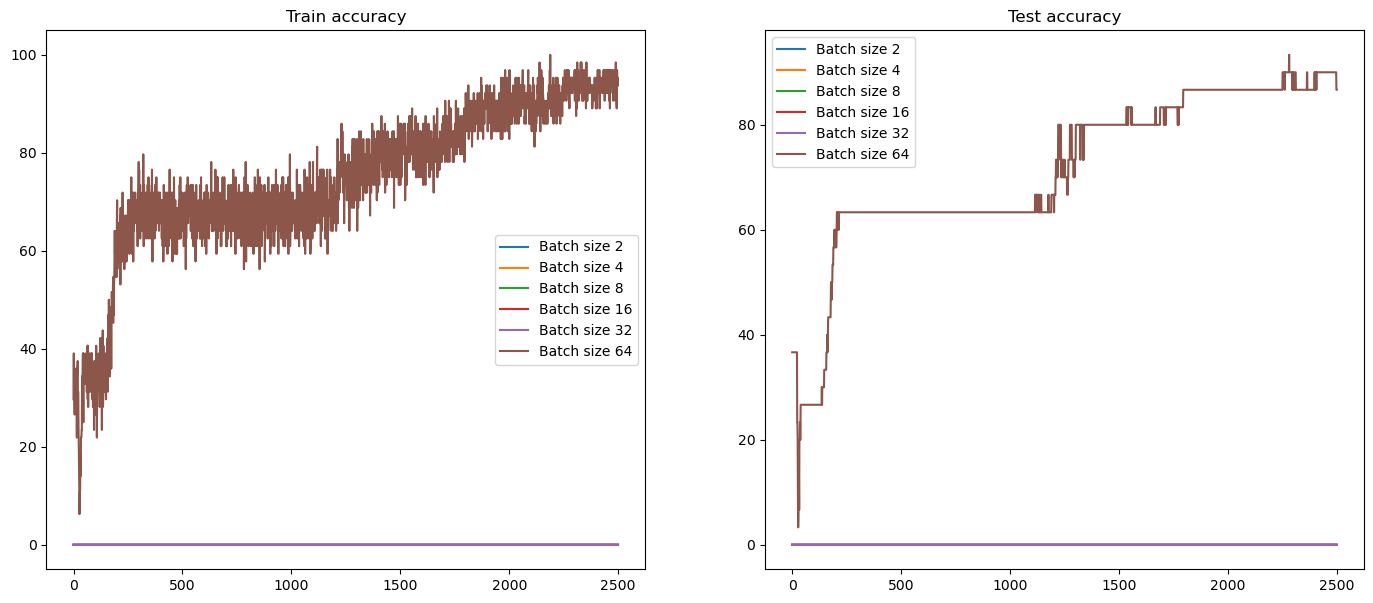

In [89]:
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
ax[0].legend(['Batch size 2', 'Batch size 4', 'Batch size 8', 'Batch size 16', 'Batch size 32', 'Batch size 64'])
ax[1].legend(['Batch size 2', 'Batch size 4', 'Batch size 8', 'Batch size 16', 'Batch size 32', 'Batch size 64'])
plt.show()